Modules nécessaires : 

In [39]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

from HiggsML.ingestion import Ingestion
from HiggsML.datasets import download_dataset
from sample_code_submission.neural_network import NeuralNetwork
from sys import path
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from itertools import product
from numpy.random import RandomState
import warnings
import os
import sys

warnings.filterwarnings("ignore")

Charger les données : 

In [40]:
data = download_dataset(
    "blackSwan_data"
)  # change to "blackSwan_data" for the actual data

# load train set
data.load_train_set()
data_set = data.get_train_set()

2025-06-04 09:38:57,868 - HiggsML.datasets     - INFO     - Handling as dataset name: blackSwan_data
2025-06-04 09:38:57,868 - HiggsML.datasets     - INFO     - Current working directory: c:\Users\marwa\Desktop\Neural Network\Higgs_collaboration_A
2025-06-04 09:38:57,872 - HiggsML.datasets     - INFO     - Total rows: 2000000
2025-06-04 09:38:57,872 - HiggsML.datasets     - INFO     - Test size: 600000
2025-06-04 09:38:57,955 - HiggsML.datasets     - INFO     - Selected train size: 1400000
2025-06-04 09:38:59,139 - HiggsML.datasets     - INFO     - Data loaded successfully


In [41]:
target = data_set["labels"]
weights = data_set["weights"]
detailed_label = data_set["detailed_labels"]
keys = np.unique(detailed_label)

Direction

In [42]:
root_dir = os.getcwd()
print("Root directory is", root_dir)
submission_dir = os.path.join(root_dir, "sample_code_submission")

# The directory where results and other outputs from the participant's code will be written
output_dir = os.path.join(root_dir, "sample_result_submission")

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

Root directory is c:\Users\marwa\Desktop\Neural Network\Higgs_collaboration_A


Import Submission Model

In [43]:
path.append(submission_dir)
from model import Model

Testing Settings

In [44]:
TEST_SETTINGS = {
    "systematics": {  # Systematics to use
        "tes": False,  # tau energy scale
        "jes": False,  # jet energy scale
        "soft_met": False,  # soft term in MET
        "ttbar_scale": False,  # W boson scale factor
        "diboson_scale": False,  # Diboson scale factor
        "bkg_scale": False,  # Background scale factor
    },
    "num_pseudo_experiments": 25,  # Number of pseudo-experiments to run per set
    "num_of_sets": 25,  # Number of sets of pseudo-experiments to run
}

RANDOM_SEED = 42


In [45]:
test_settings = TEST_SETTINGS.copy()

random_state = np.random.RandomState(RANDOM_SEED)
test_settings["ground_truth_mus"] = (
    random_state.uniform(0.1, 3, test_settings["num_of_sets"])
).tolist()

random_settings_file = os.path.join(output_dir, "test_settings.json")
with open(random_settings_file, "w") as f:
    json.dump(test_settings, f)

Boucle sur "Ingestion" en faisant varier epochs

Fonction bouclée: 

In [46]:
L_epochs = np.linspace(2, 3, 2)
sigmax = 5000
epochs_max = 1

Significance

In [ ]:

def optimization(train_data): 
    for k in range(len(L_epochs)):
        path.append(submission_dir)
        ingestion = Ingestion(data)
        ingestion.epochs = L_epochs[k]
        print(ingestion.epochs)
        # initialize submission
        ingestion.init_submission(Model, "NN")
        ingestion.fit_submission()
        sig1 = ingestion.model.model.significance_2(test_labels=ingestion.model.training_set["labels"],test_weights=ingestion.model.training_set["weights"])
        #visualisation des données :
        if sig1>sigmax: 
            sigmax = sig1
            epochs_max = L_epochs[k]
    return sigmax, epochs_max



SyntaxError: unmatched ')' (709021805.py, line 10)

Lancement de la boucle

2025-06-04 09:22:57,666 - HiggsML.ingestion    - INFO     - Initializing Submmited Model
2025-06-04 09:22:57,666 - HiggsML.datasets     - INFO     - Selected train size: 5000


2.0


2025-06-04 09:22:58,024 - HiggsML.datasets     - INFO     - Data loaded successfully
2025-06-04 09:22:58,048 - HiggsML.datasets     - INFO     - Selected train size: 5000


Training Data:  (5000, 28)
Training Labels:  (5000,)
Training Weights:  (5000,)
sum_signal_weights:  683.479148003075
sum_bkg_weights:  105035.5208519969


2025-06-04 09:22:58,387 - HiggsML.datasets     - INFO     - Data loaded successfully
2025-06-04 09:22:58,419 - HiggsML.datasets     - INFO     - Selected train size: 5000



Valid Data:  (5000, 28)
Valid Labels:  (5000,)
Valid Weights:  (5000,)
sum_signal_weights:  654.4884403628453
sum_bkg_weights:  105064.51155963715


2025-06-04 09:22:58,787 - HiggsML.datasets     - INFO     - Data loaded successfully
2025-06-04 09:22:58,852 - HiggsML.ingestion    - INFO     - Calling fit method of submitted model



Holdout Data:  (5000, 28)
Holdout Labels:  (5000,)
Holdout Weights:  (5000,)
sum_signal_weights:  663.5817216034541
sum_bkg_weights:  105055.41827839655
 
 
Training Data:  (5000, 28)
DEBUG: model_type = 'NN'
 Model is NN
Epoch 1/5
157/157 - 2s - 11ms/step - accuracy: 0.6626 - loss: 27.3568
Epoch 2/5
157/157 - 0s - 2ms/step - accuracy: 0.7078 - loss: 24.0545
Epoch 3/5
157/157 - 0s - 2ms/step - accuracy: 0.7346 - loss: 22.7428
Epoch 4/5
157/157 - 0s - 2ms/step - accuracy: 0.7462 - loss: 22.0911
Epoch 5/5
157/157 - 0s - 2ms/step - accuracy: 0.7582 - loss: 21.6605
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score shape before threshold (4577,)
score shape after threshold (4577,)
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
saved_info {'beta': np.float64(24616.991169386027), 'gamma': np.float64(496.1041130281729), 'tes_fit': <function tes_fitter.<locals>.fit_function at 0x000001C338E48E00>, 'jes_fit': <function jes_fitter.<locals>.fit_function at 0x0000

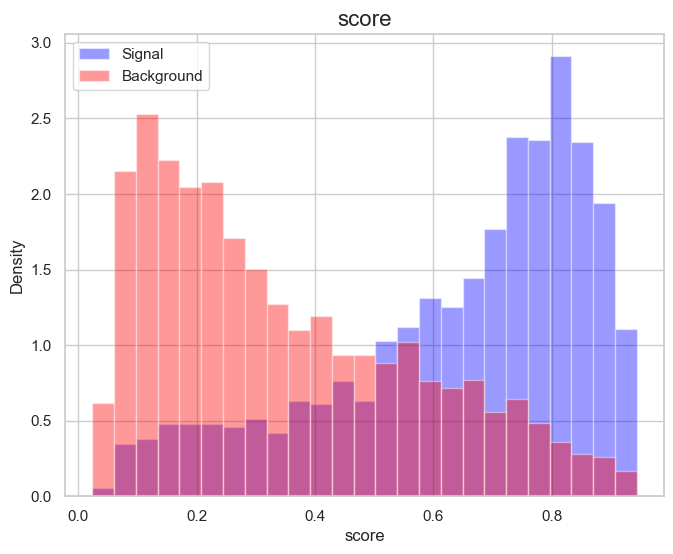

keys ['diboson' 'htautau' 'ttbar' 'ztautau']
keys 2 dict_keys(['diboson', 'htautau', 'ttbar', 'ztautau'])
htautau (30,)


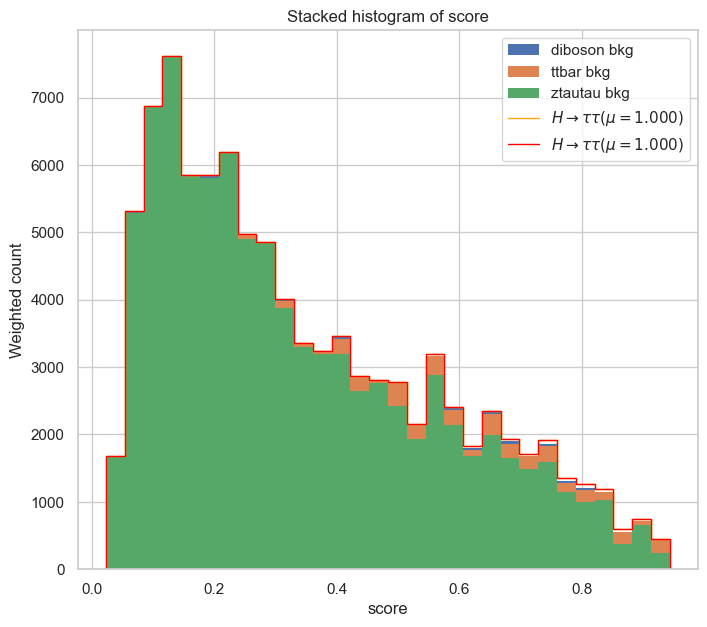

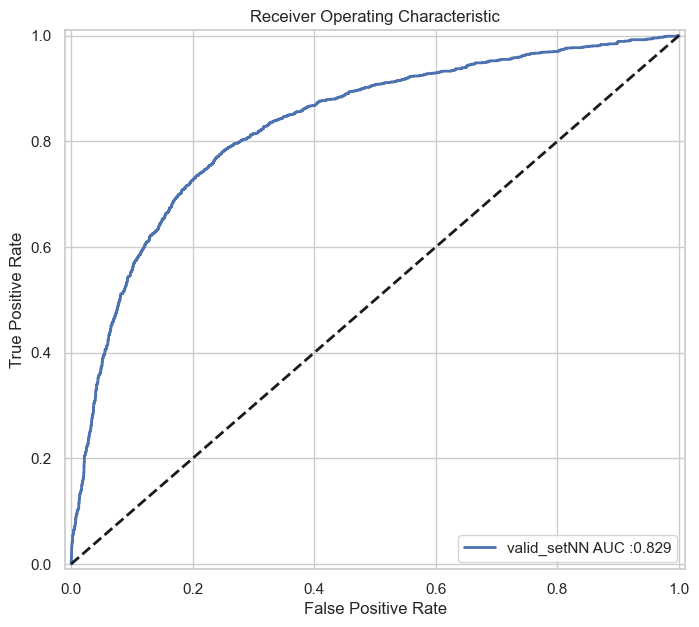

AttributeError: type object 'Model' has no attribute 'significance'

In [ ]:
optimization(data_set)